In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from utility.types import (
    RebalanceFrequencyEnum,
    AllocationMethodsEnum,
    RegimeDetectionModels,
)

from data.universe import Universe
from data.benchmark import Benchmark

from backtest.backtest import Backtester

In [2]:
bench_obj = Benchmark(RebalanceFrequencyEnum.MONTH_END)
bench_obj.benchmark_perf

2016-05-19    1.000000
2016-05-20    1.000000
2016-05-23    1.000000
2016-05-24    1.000000
2016-05-25    1.000000
                ...   
2024-03-01    1.658112
2024-03-04    1.661620
2024-03-05    1.655421
2024-03-06    1.660339
2024-03-07    1.671945
Freq: B, Name: benchmark_perf, Length: 2036, dtype: float64

In [3]:
univ_obj = Universe()
universe = univ_obj.get_universe_returns()
universe

,EUROPE _VALUE_FACTOR,EUROPE _MOMENTUM_FACTOR,WATER_ESG,STOXX_EUROPE 600_TECHNOLOGY,STOXX_EUROPE 600_HEALTHCARE,EURO_GOV_1-3Y,EURO_GOV_3-5Y,EURO_GOV_7-10Y,EURO_GOV_10-15Y,SX5T_levier_2,NASDAQ-100_LEVIER_2,Px fut SX5E,Px fut sp500,Px fut nasdaq,SX5T,SPTR500N,ESTR_ETF
2016-05-24,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2016-05-25,0.016784,0.004475,0.007284,0.014626,0.016174,-0.000040,0.000982,0.002813,0.005023,0.036014,0.017772,0.016672,0.005904,0.006636,0.000000,0.000000,0.000000
2016-05-26,0.002733,0.003588,0.000868,0.002402,-0.000120,0.000040,0.000262,0.000409,-0.000238,0.006796,0.003687,0.003936,0.001198,0.003911,0.000000,0.000000,0.000000
2016-05-27,0.000428,0.003359,0.005491,0.006626,0.007540,-0.000040,-0.000327,-0.000935,-0.000095,0.005971,0.015969,0.001307,0.003589,0.003951,0.000000,0.000000,0.000000
2016-05-30,0.002297,0.002643,-0.000862,0.001821,0.001544,-0.000079,-0.000065,0.000058,-0.000667,0.007484,0.005474,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-01,0.004568,0.004620,0.005994,0.015707,0.013283,-0.000248,-0.000557,-0.001363,-0.003010,0.006408,0.026371,0.001430,0.008278,0.014129,0.001428,0.005785,0.000000
2024-03-04,-0.003465,0.002453,0.003610,0.007408,0.004546,0.000166,0.000558,0.002233,0.003696,0.006753,0.006654,0.003469,-0.001506,-0.004158,0.004018,0.000539,0.000000
2024-03-05,0.002646,-0.001733,-0.005968,-0.016467,-0.005092,0.001160,0.002509,0.006745,0.009387,-0.008049,-0.037828,-0.004270,-0.010217,-0.018166,-0.004131,-0.008862,0.000392
2024-03-06,0.003564,0.004187,0.000316,0.012498,0.001467,-0.000414,0.000487,0.000492,0.001387,0.010433,0.009723,0.005105,0.005112,0.006358,0.005315,0.001269,0.000196



-------  Returns statistical information  --------
Expected return annualized: 6.74 % vs 6.97 % (buy and hold)
CAGR: 6.06 % vs 6.42 % (buy and hold)
Expected volatility annualized: 12.87 % vs 11.76 % (buy and hold)
Specific volatility (diversifiable) annualized: 3.98 %
Systematic volatility annualized: 12.24 %
Skewness: -0.83 vs -0.63 (buy and hold), <0 = left tail, >0 = right tail
Kurtosis: 9.33 vs -0.63 (buy and hold) , >3 = fat tails, <3 = thin tails
95%-VaR: -1.24 % vs -1.12 % (buy and hold) -> the lower the better
95%-CVaR: -2.01 % vs -1.84 % (buy and hold) -> the lower the better

-------  Strategy statistical information  -------
Max drawdown: -27.81 % vs -25.88 % (buy and hold)
Kelly criterion: 4.94 % vs 5.83 % (buy and hold)
Benchmark sensitivity (beta): 1.04 vs 1 (buy and hold)
Determination coefficient R²: 0.90
Tracking error annualized: 4.01 %

---------------  Strategy ratios  ----------------
No risk free rate considered for the following ratios.

Sharpe ratio annualized

c:\_sharedFS\Ecole\Cross-Asset-Investment-Solutions\Cross-Asset-Investment-Solutions\.venv\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


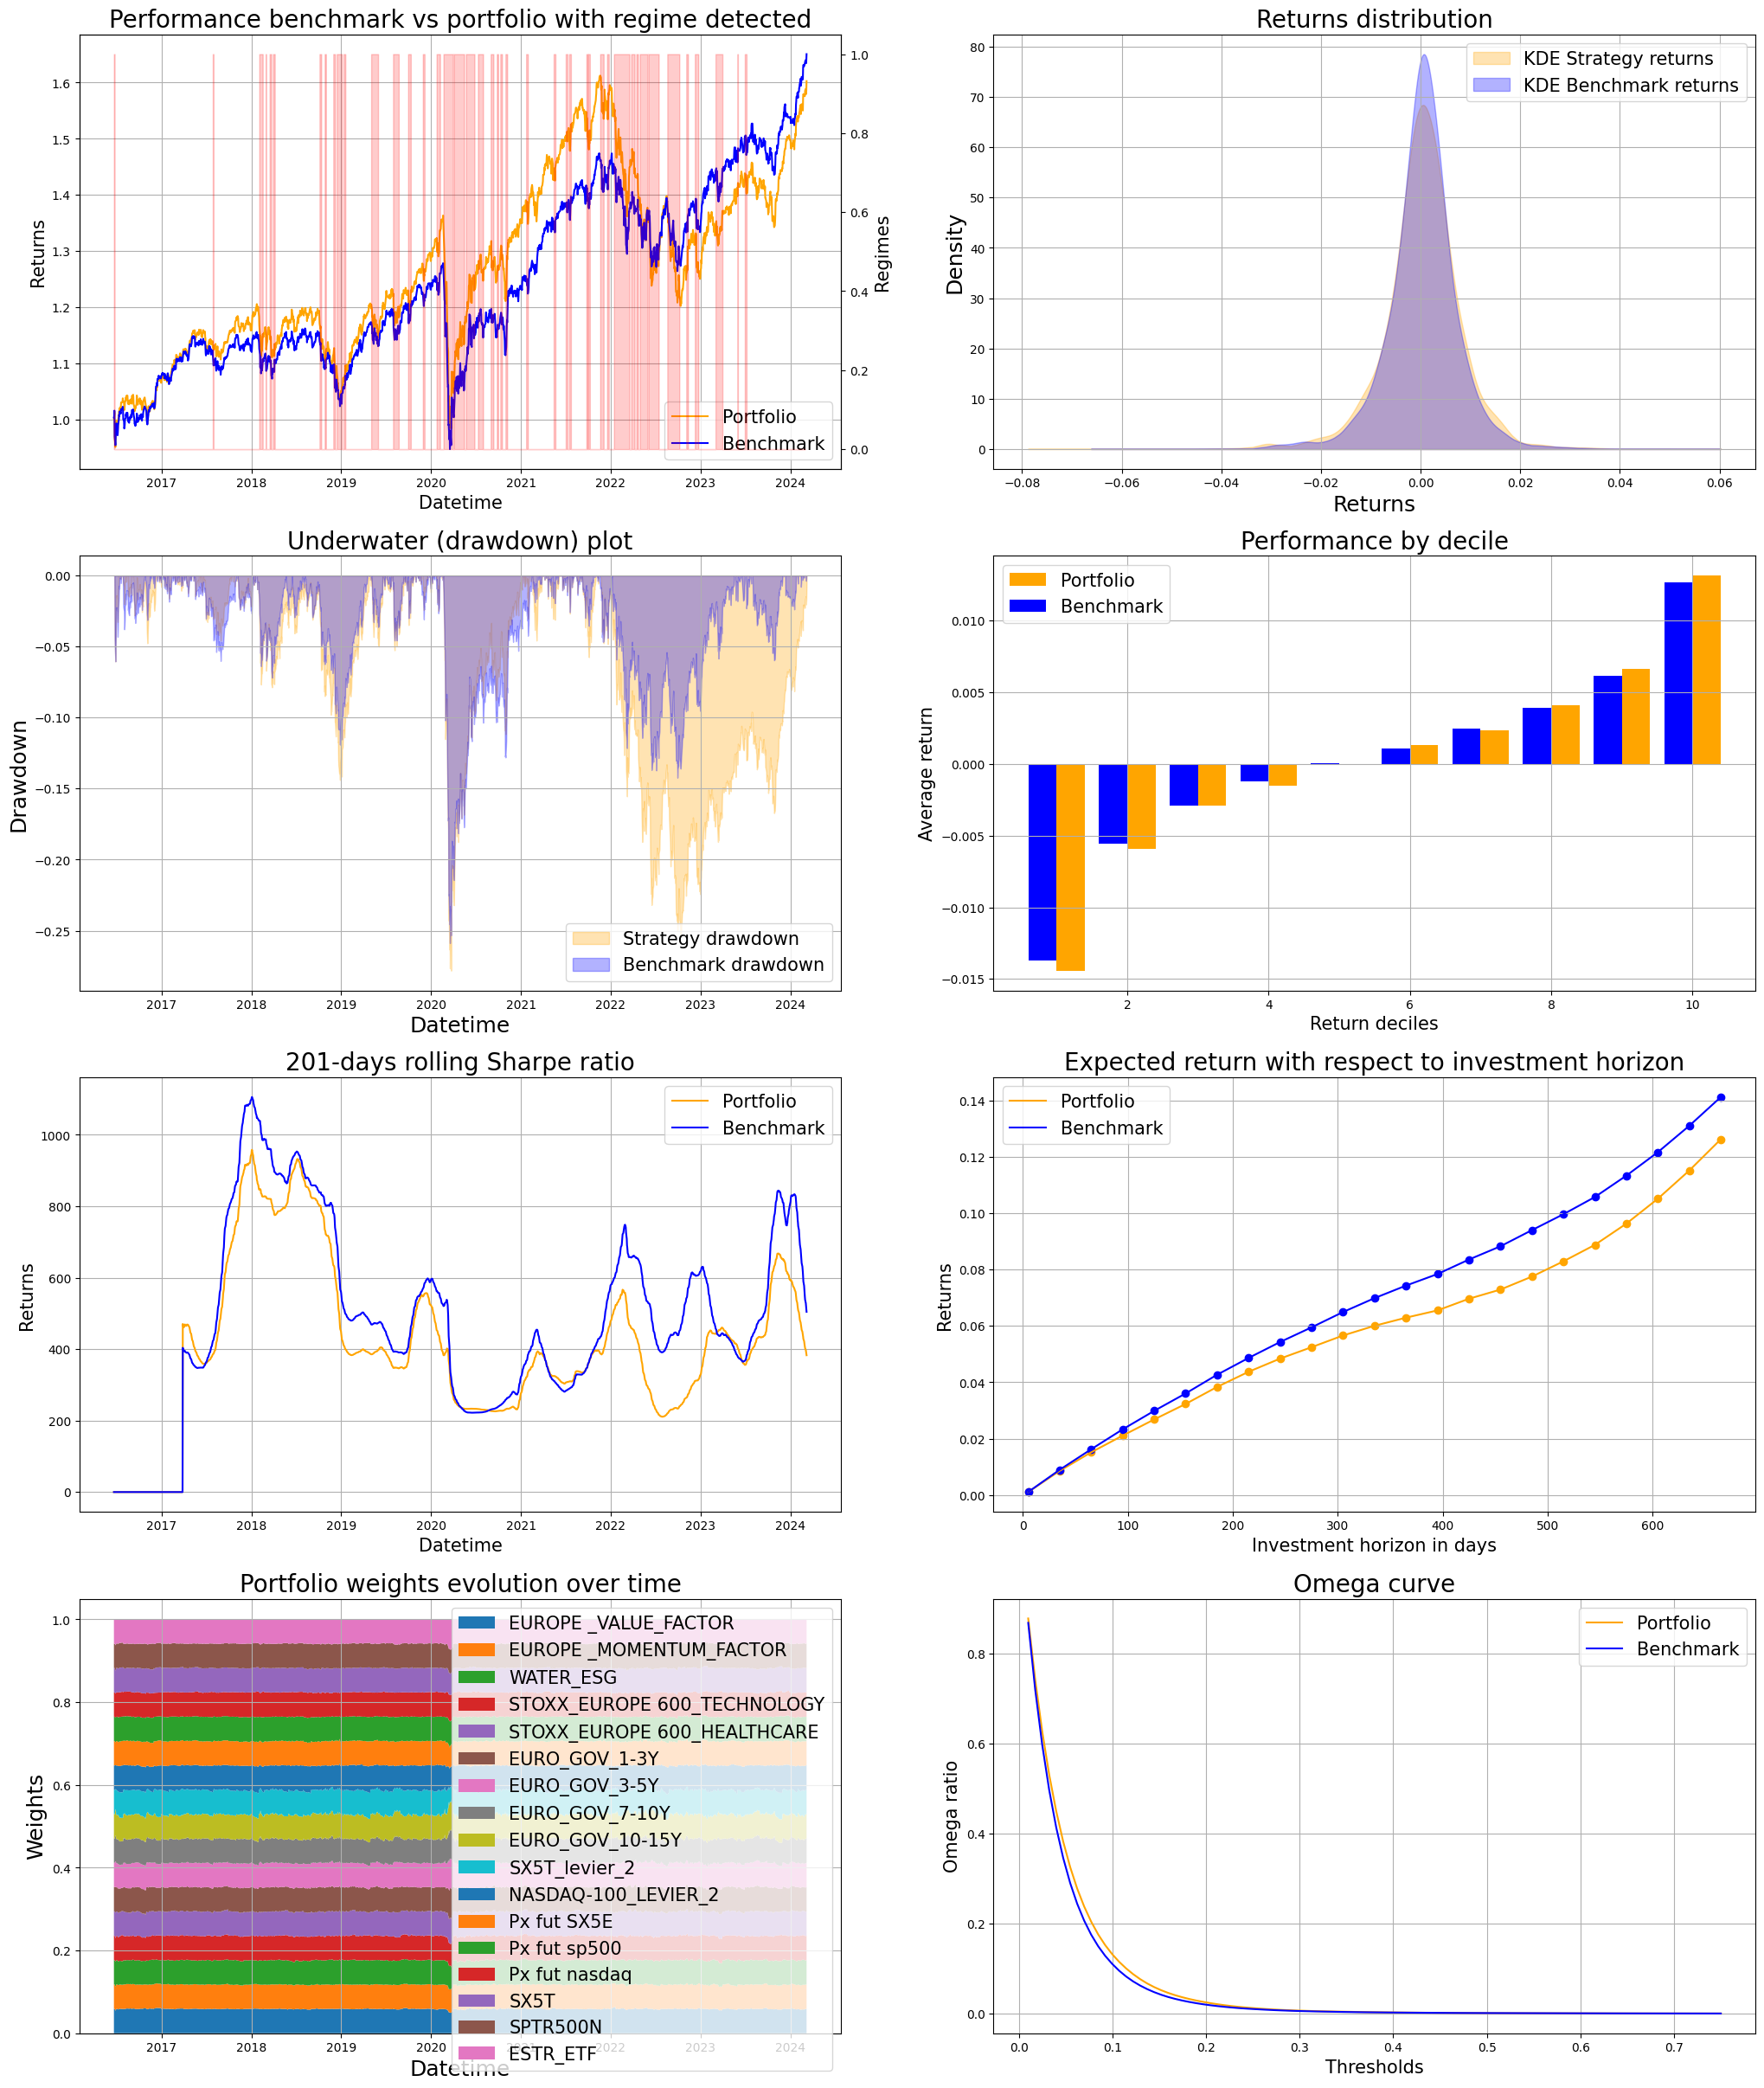

In [4]:
bk_tester = Backtester(
    universe_returns=univ_obj.get_universe_returns(),
    market_returns=bench_obj.benchmark_returns,
    benchmark_returns=bench_obj.benchmark_returns,
)


ptf_and_bench, ptf_weights_equal_weight, regimes, metrics_df = bk_tester.run_backtest(
    allocation_type=AllocationMethodsEnum.EQUALLY_WEIGHTED,
    rebalance_frequency=RebalanceFrequencyEnum.MONTH_END,
    market_regime_model=RegimeDetectionModels.HIDDEN_MARKOV_MODEL,
    transaction_cost_by_securities={k: 0.0015 for k in universe.columns},
    bearish_leverage_by_securities={k: 1 for k in universe.columns},
    bullish_leverage_by_securities={k: 1 for k in universe.columns},
    verbose=False,
)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(25, 10))


ax.plot(regimes.index, regimes.next_beta, label="Beta")
ax_l = ax.twinx()
ax_l.fill_between(
    regimes.index,
    regimes["Regime"],
    alpha=0.2,
    color="red",
    step="pre",
)
ax.set_xlabel("Datetime", fontsize=15)
ax.set_ylabel("Beta", fontsize=15)
ax.set_title(f"Dynamic beta evolution", fontsize=20)
ax.grid()
ax.legend(fontsize=15)